In [43]:
library("data.table")
library("here")
library("DESeq2")
library("SummarizedExperiment")
library("readr")
library("ggplot2")
library("EnhancedVolcano")
library("biomaRt")

# get the project directory, everything is set relative to this
proj_dir = here()

gene_expr_file <- file.path(proj_dir, "/GEO_Submission_Bitler/salmon_quant_processed/salmon_gene_quant.RDS")
res_file <- file.path(proj_dir, "/GEO_Submission_Bitler/deseq_results/deseq_results.tsv")

data_formatted_file <- file.path(proj_dir, "/GEO_Submission_Bitler/deseq_results/formatted_expr.tsv")

In [44]:

# read in original RNASeq files
gene_summarized <- readr::read_rds(gene_expr_file)
gene_count <- assay(gene_summarized, "counts")
sample_ids = colnames(gene_count)

gene_count_df = data.frame(gene_count)



# plot the stats

In [45]:
gene_count = cbind(gene_count, row.names(gene_count))
colnames(gene_count)[5] = "gene_id"

gene_count_melt <- melt(data.table(gene_count), id.vars="gene_id")
colnames(gene_count_melt) = c("gene_id", "sample_id", "count")

# order samples by median expression
sample_order_df = data.frame(median_count = apply(gene_count_df, 2, median),
                             sample_id = colnames(gene_count_df))

sample_order_df = sample_order_df[order(sample_order_df$median_count),]
gene_count_melt$sample_id = factor(gene_count_melt$sample_id, 
                                    levels = sample_order_df$sample_id)


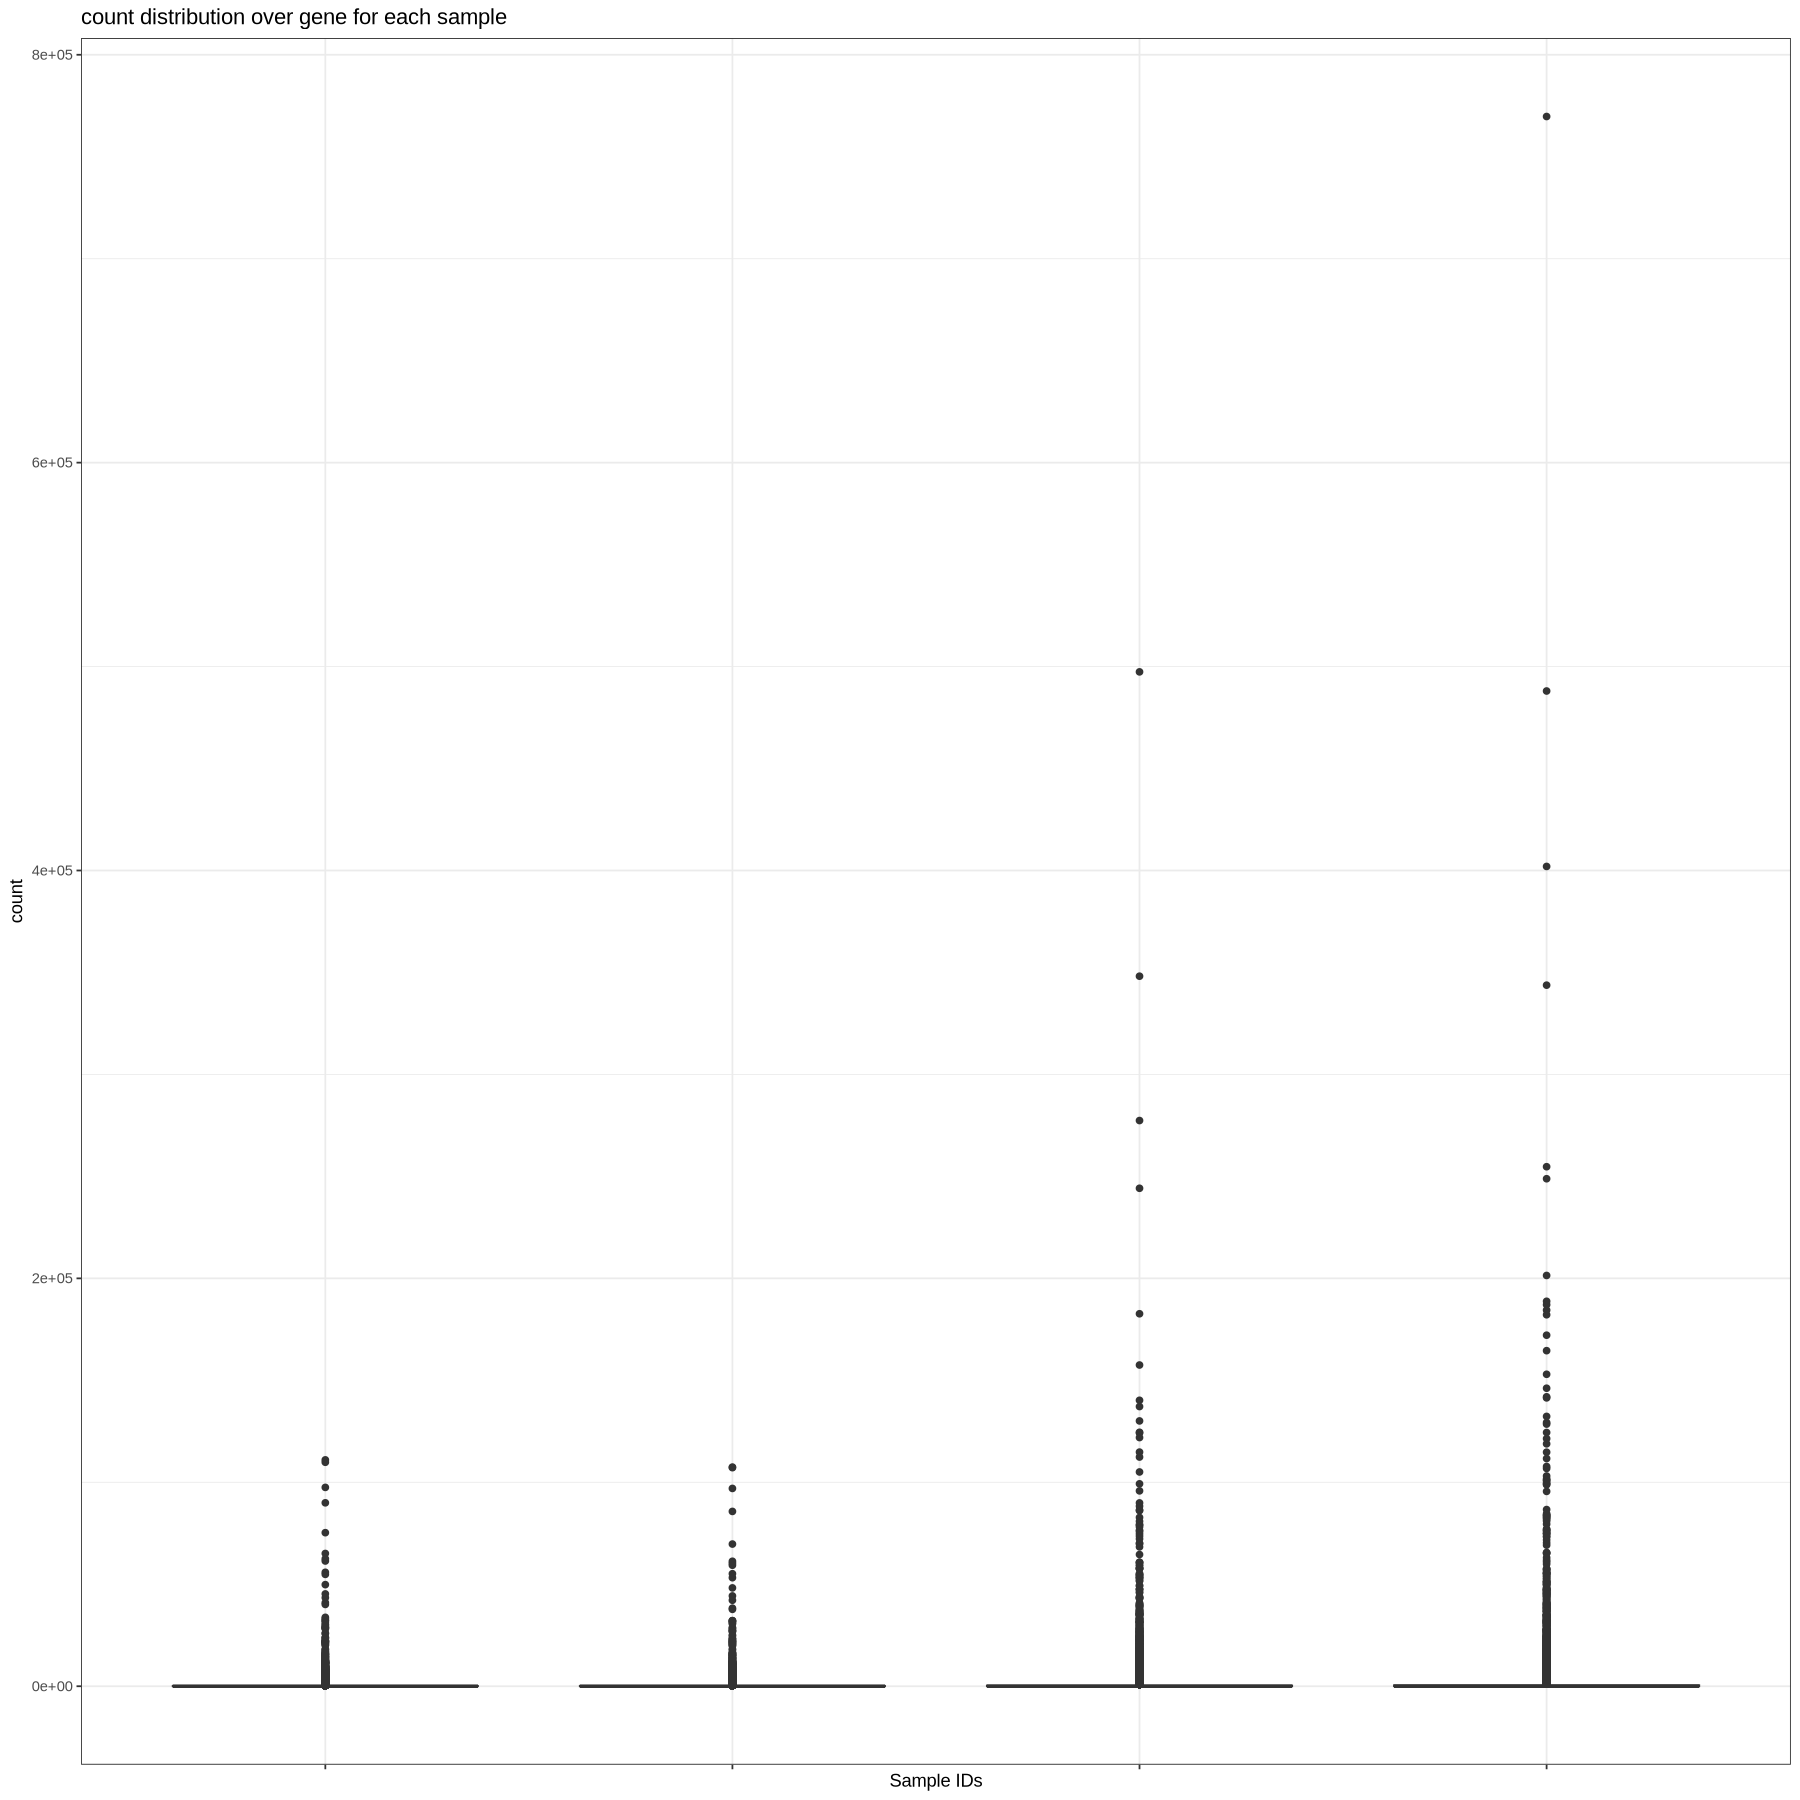

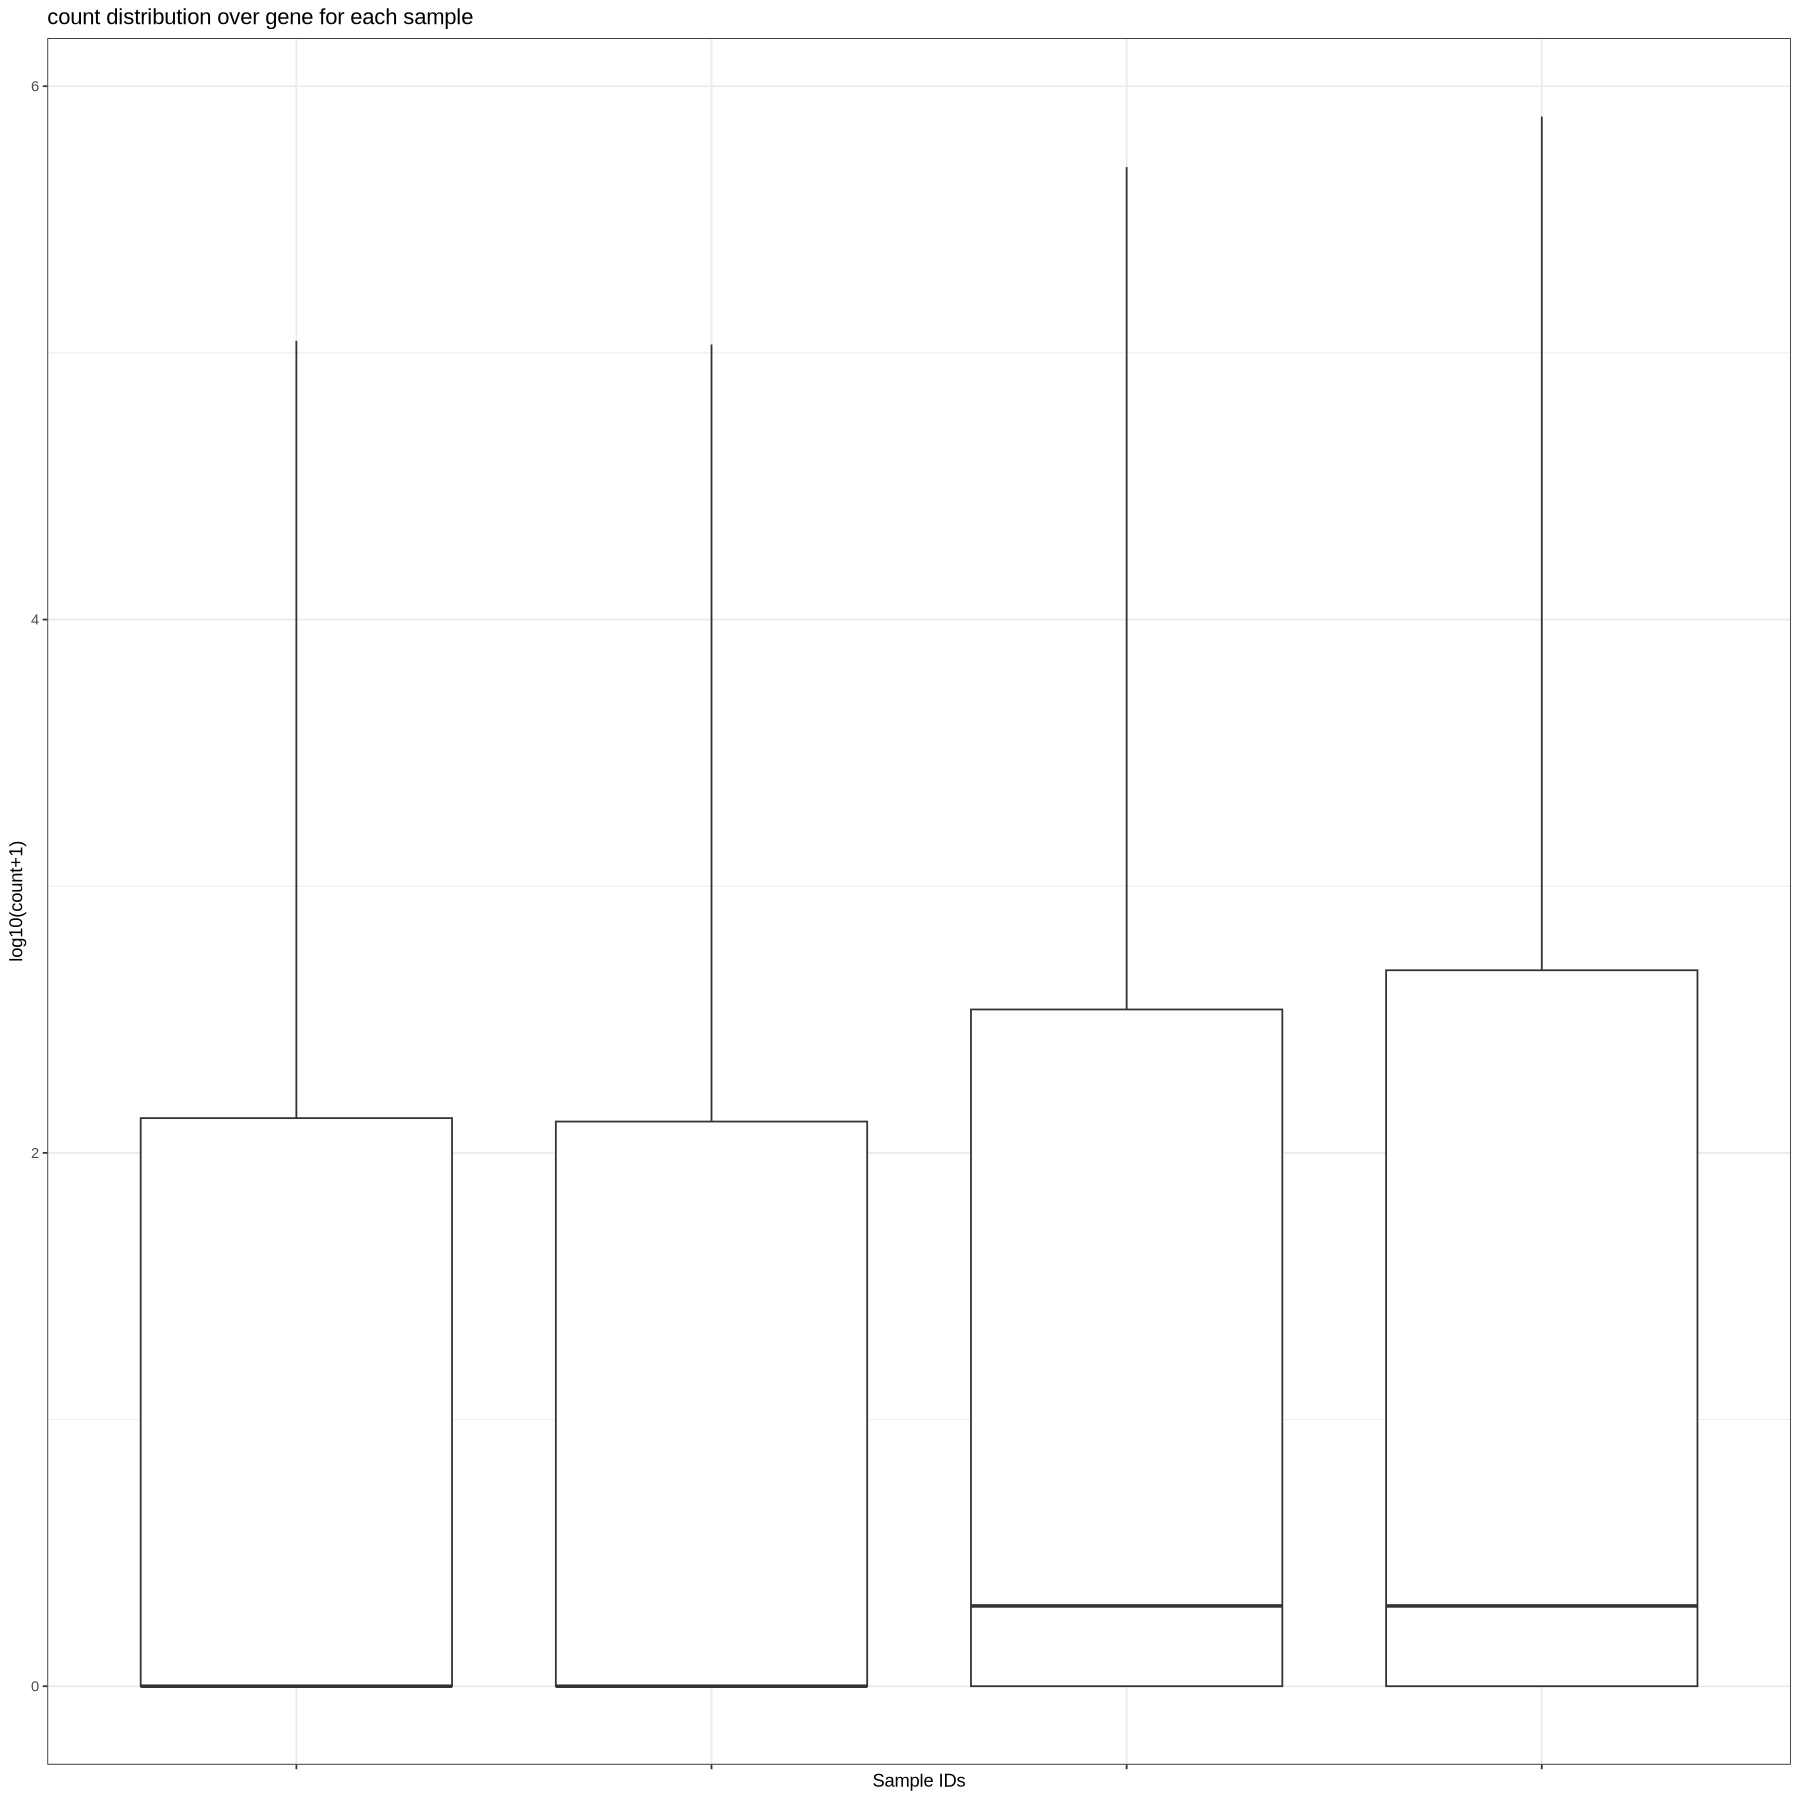

In [46]:

ggplot(gene_count_melt, aes(x=as.factor(sample_id), y=as.numeric(count))) +
    geom_boxplot() + theme_bw() +
    theme(axis.text.x = element_blank()) +
    xlab("Sample IDs") + ylab("count") +
        ggtitle("count distribution over gene for each sample")


ggplot(gene_count_melt, aes(x=as.factor(sample_id), y=log10(as.numeric(count)+1))) +
    geom_boxplot() + theme_bw() +
    theme(axis.text.x = element_blank()) +
    xlab("Sample IDs") + ylab("log10(count+1)") +
        ggtitle("count distribution over gene for each sample")


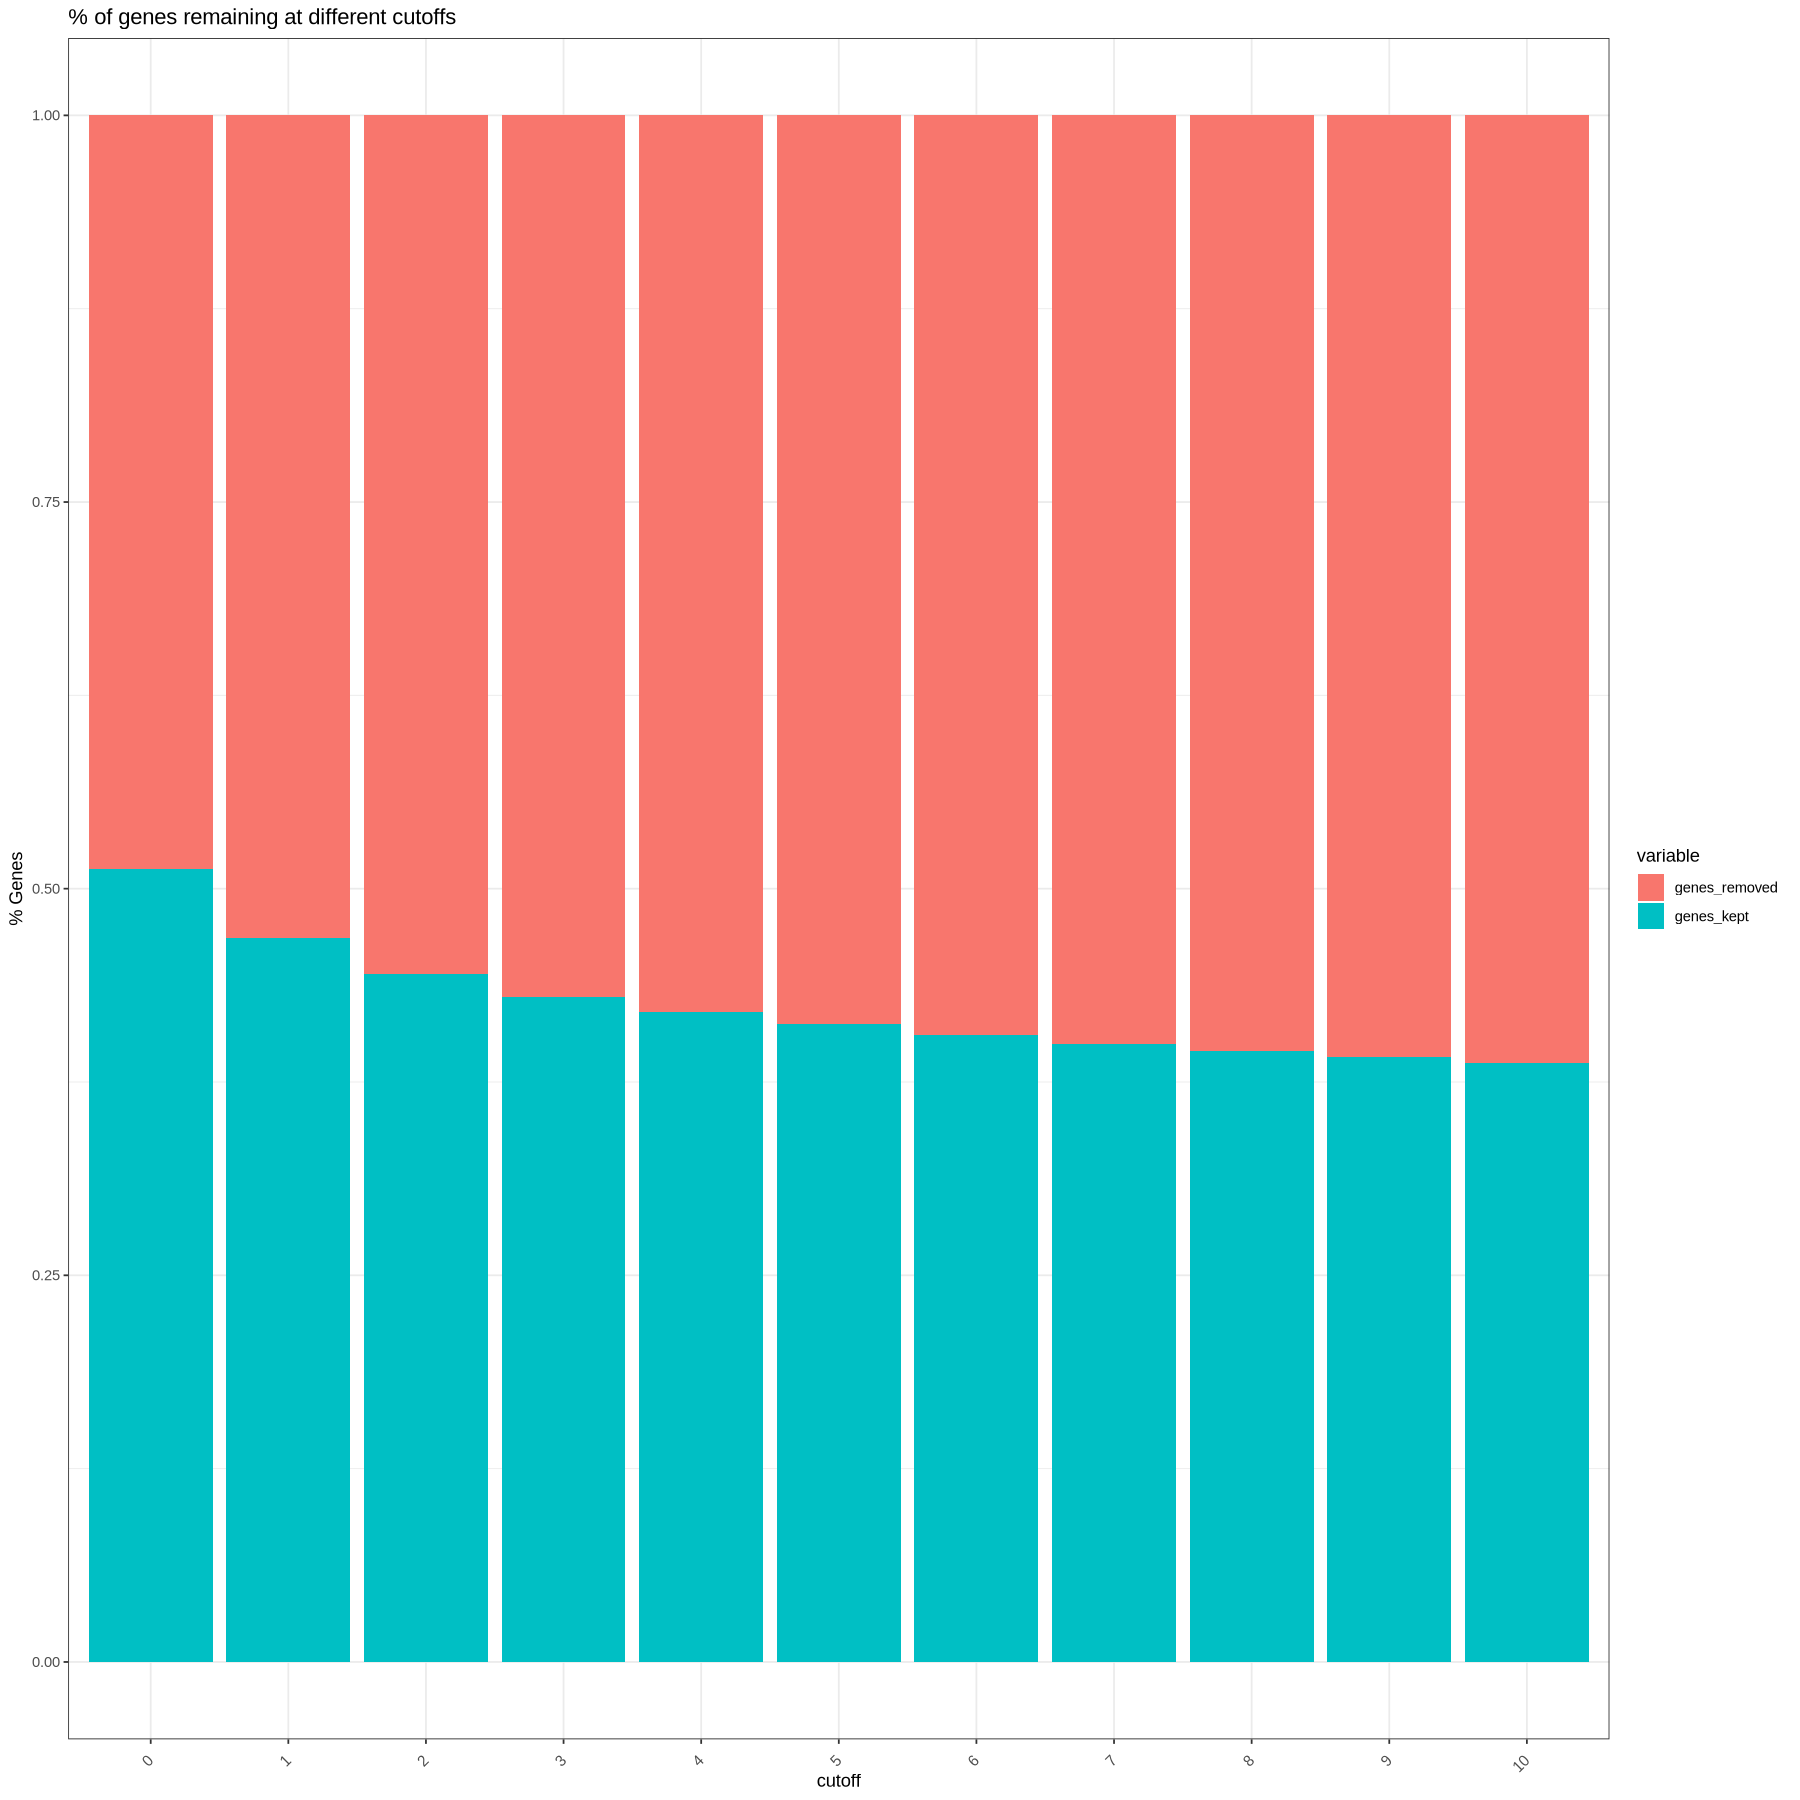

In [47]:

# now plot the stats
cutoff_df = NA
for(med_cutoff in 0:10){
    
    filtered_genes = length(which(apply(gene_count_df, 1, median)<=med_cutoff))
    cutoff_res = c(filtered_genes/nrow(gene_count_df), 
                   1-filtered_genes/nrow(gene_count_df),
                   med_cutoff)
    cutoff_df = rbind(cutoff_df, cutoff_res)

}
cutoff_df = data.frame(cutoff_df[-1,])
colnames(cutoff_df) = c("genes_removed", "genes_kept", "cutoff")
cutoff_df$cutoff = factor(cutoff_df$cutoff)
cutoff_df = melt(data.table(cutoff_df), id.vars=c("cutoff"))

ggplot(cutoff_df, aes(x=cutoff, y=value, fill=variable)) +
   geom_bar(stat="identity", position="stack") + theme_bw() +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1)) +
    ylab("% Genes") + xlab("cutoff") +
        ggtitle("% of genes remaining at different cutoffs")


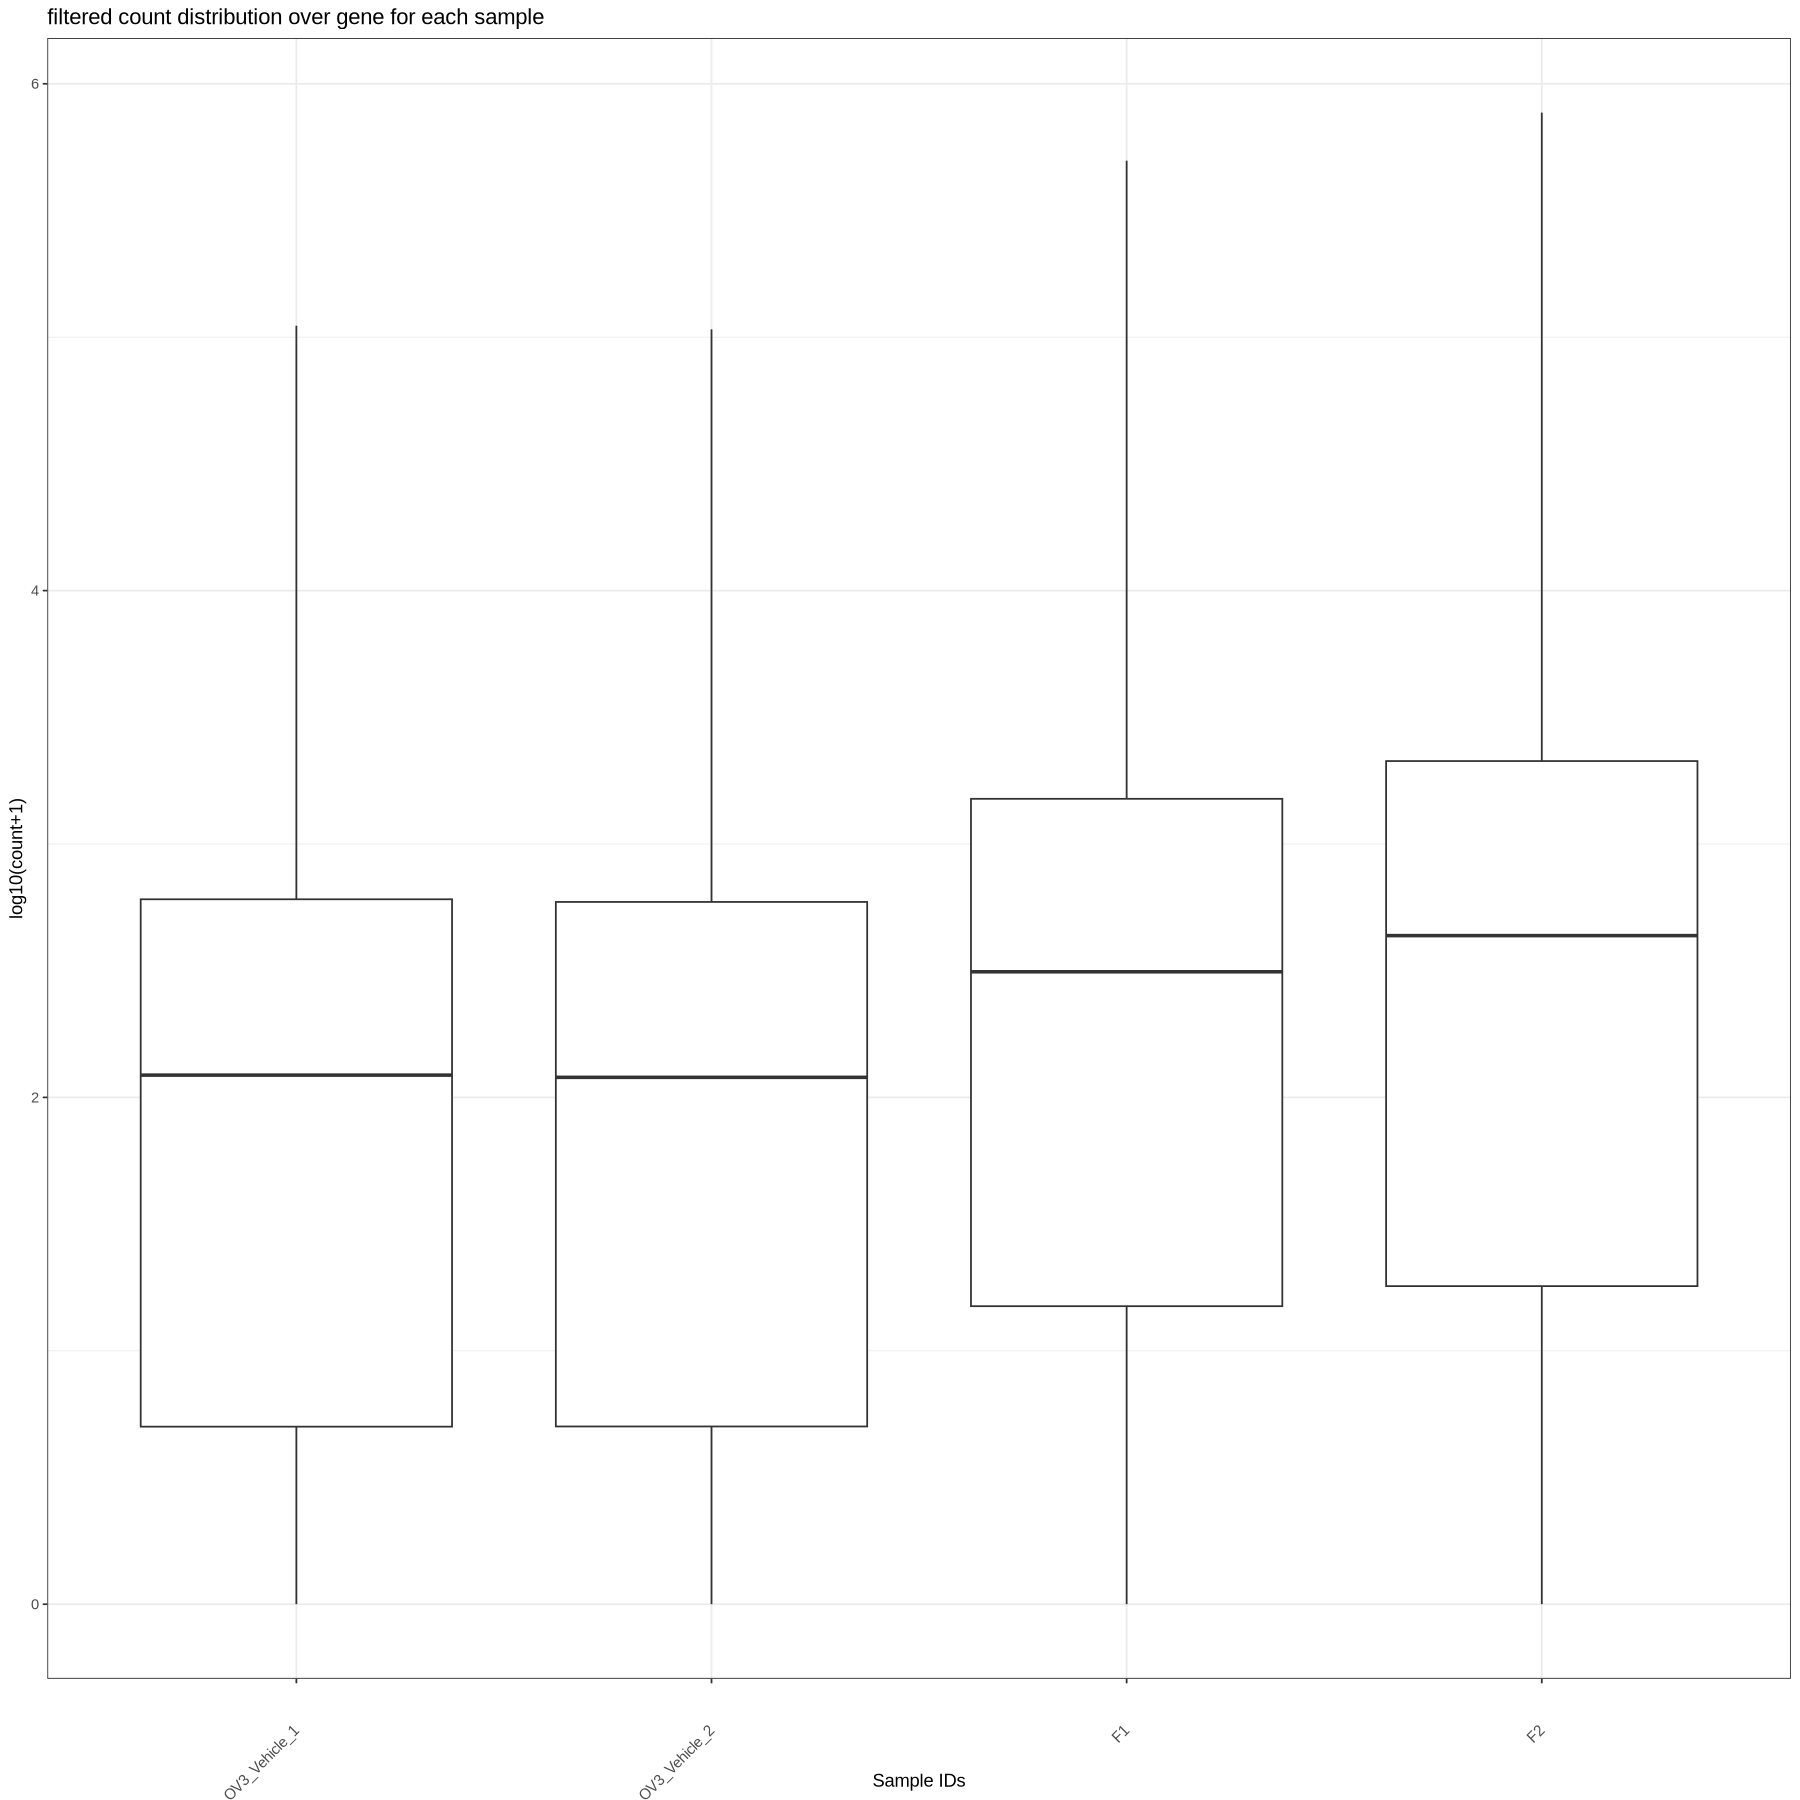

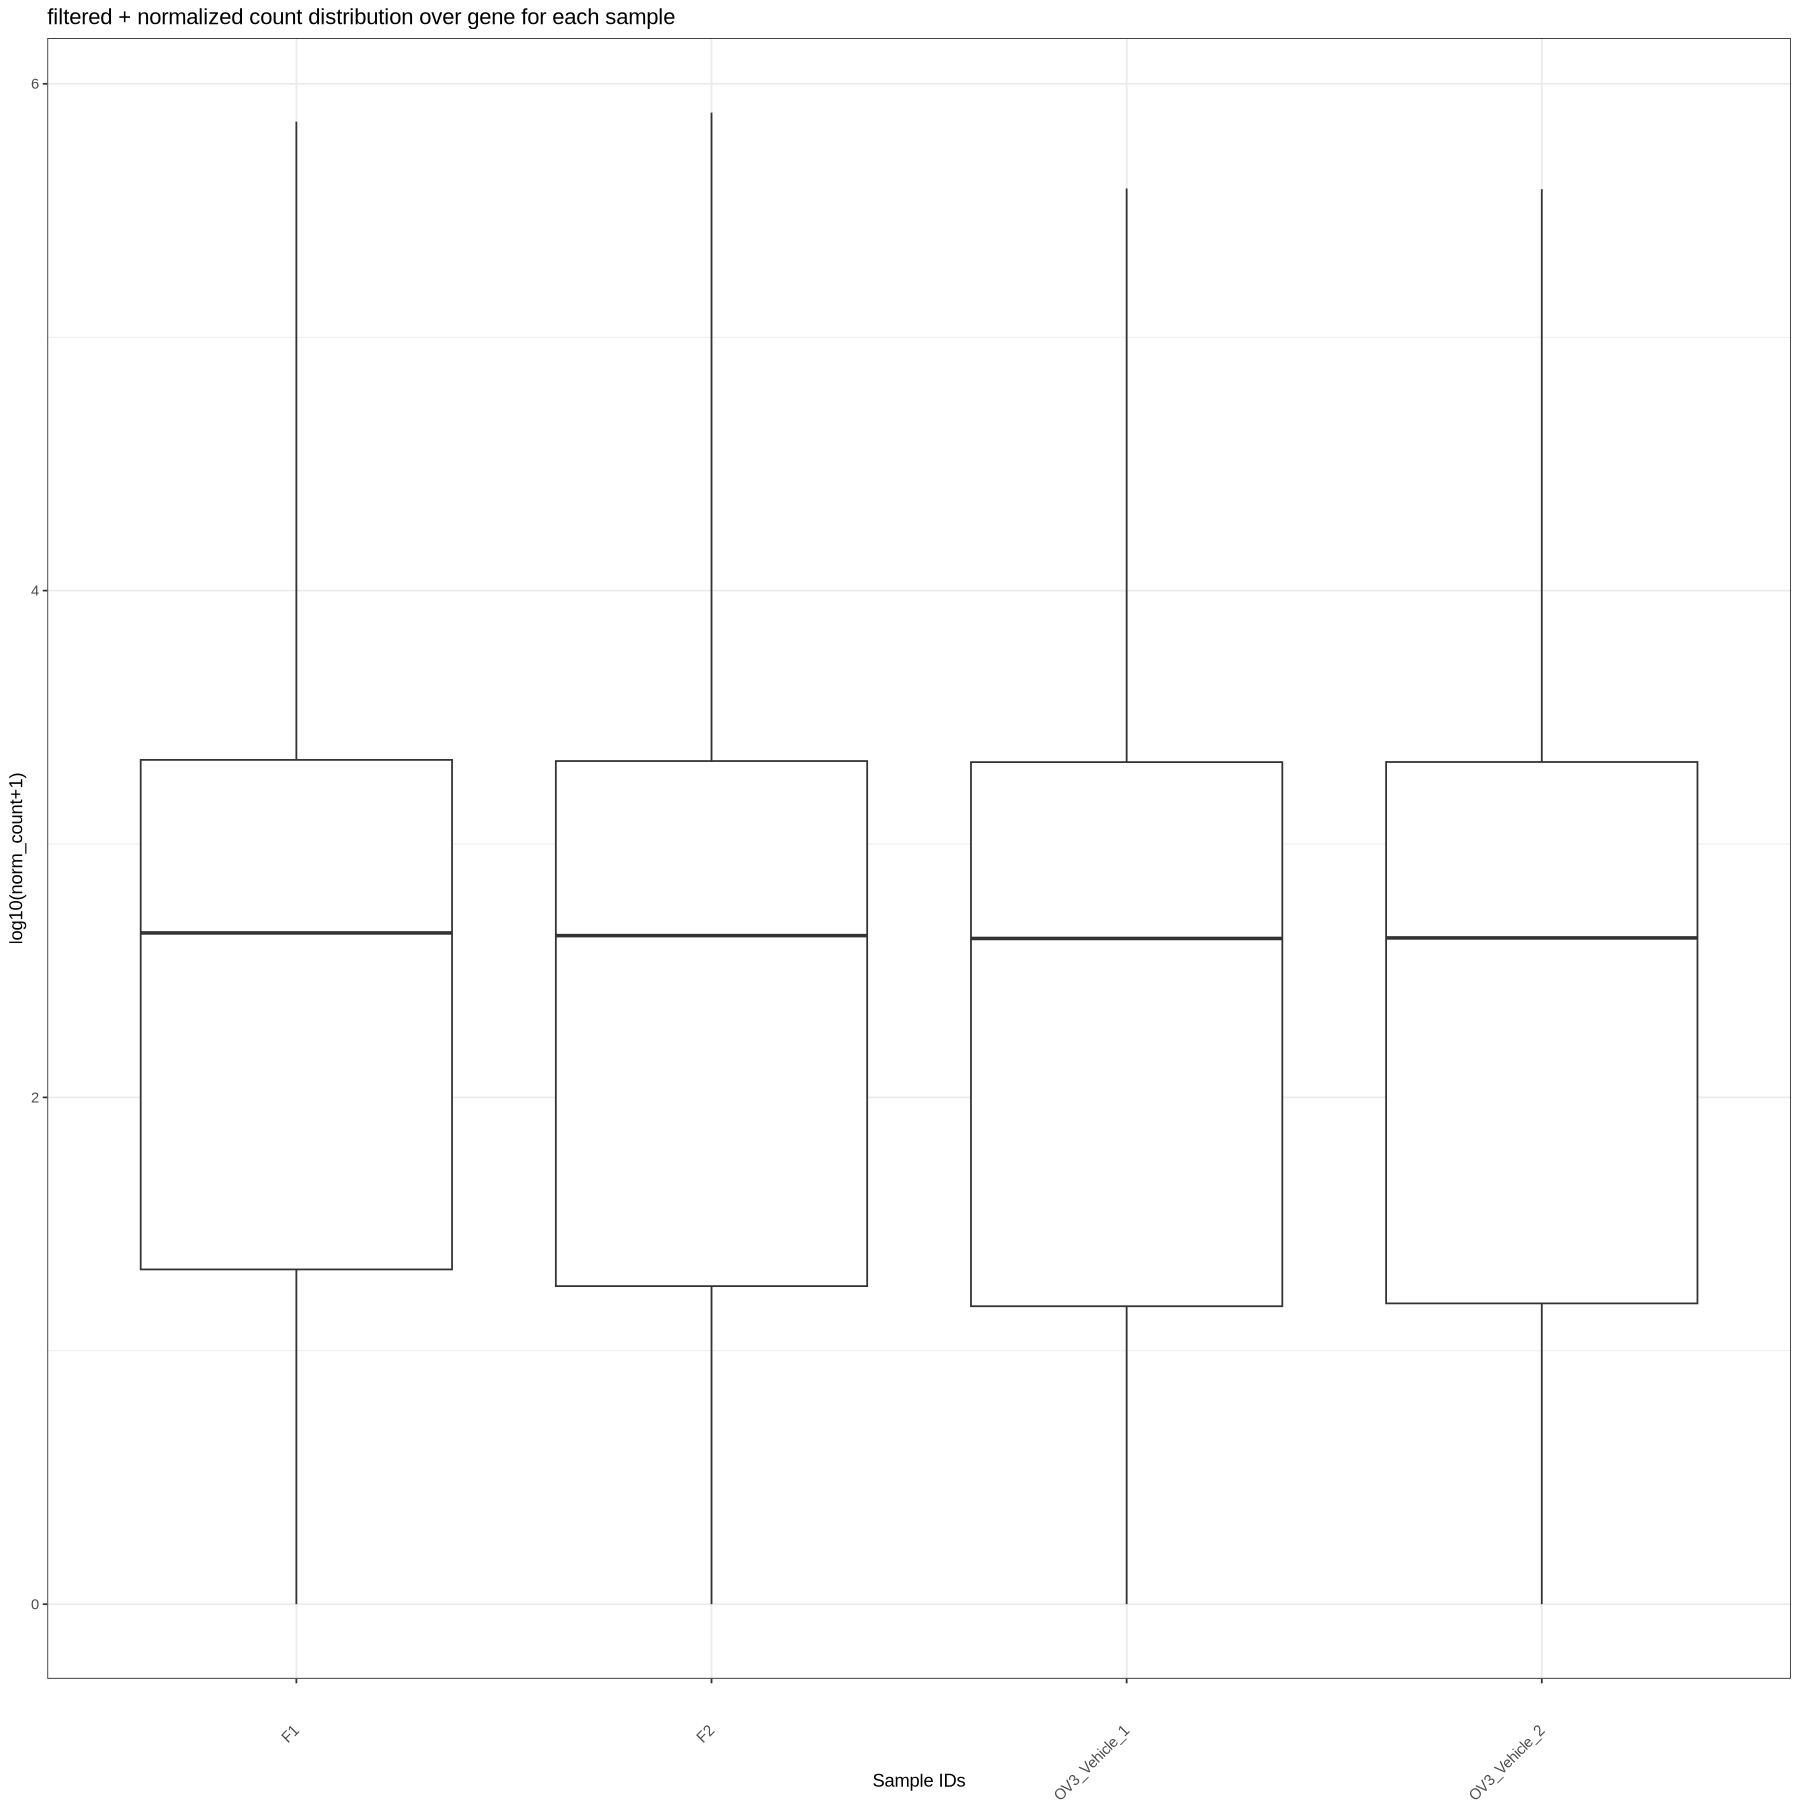

In [48]:
# now plot the filtered version
filtered_genes = rownames(gene_count_df)[which(apply(gene_count_df, 1, median)==0)]
gene_count_df_filt = subset(gene_count_melt, ! gene_id %in% filtered_genes)



ggplot(gene_count_df_filt, aes(x=as.factor(sample_id), y=log10(as.numeric(count)+1))) +
    geom_boxplot() + theme_bw() +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1)) +
    xlab("Sample IDs") + ylab("log10(count+1)") +
        ggtitle("filtered count distribution over gene for each sample")


# now plot the normalized version
gene_count_filt = subset(gene_count_df, 
                         ! rownames(gene_count_df) %in% filtered_genes)
samp_85th = apply(gene_count_filt, 2, quantile, 0.85)
samp_85th = samp_85th/max(samp_85th)
gene_count_filt_norm = sweep(gene_count_filt, 2, samp_85th, FUN = '/')

gene_count_filt_norm_melt = data.frame(gene_count_filt_norm)
gene_count_filt_norm_melt$gene_id = row.names(gene_count_filt_norm_melt)
gene_count_filt_norm_melt <- melt(data.table(gene_count_filt_norm_melt), id.vars="gene_id")
colnames(gene_count_filt_norm_melt) = c("gene_id", "sample_id", "norm_count")


# order samples by median expression
sample_order_df = data.frame(median_count = apply(gene_count_filt_norm, 2, median),
                             sample_id = colnames(gene_count_filt_norm))
sample_order_df = sample_order_df[order(sample_order_df$median_count),]


ggplot(gene_count_filt_norm_melt, aes(x=as.factor(sample_id), y=log10(as.numeric(norm_count)+1))) +
    geom_boxplot() + theme_bw() +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1)) +
    xlab("Sample IDs") + ylab("log10(norm_count+1)") +
        ggtitle("filtered + normalized count distribution over gene for each sample")


# do PCA

In [49]:

plot_pca <- function(in_df, title, color_df=NA, color_id="Subtype", scale=TRUE){

    pca_df = t(data.frame(in_df))
    keep_idx = apply(pca_df, 2, function(x) var(x) != 0)
    pca_df = pca_df[,keep_idx]

    pca_res = prcomp(pca_df, scale. = scale)
    pca_res_df = data.frame(pca_res$x)
    pca_res_df$Sample = row.names(pca_res_df)

    percentage <- round(pca_res$sdev^2 / sum(pca_res$sdev^2) * 100, 2)
    percentage <- paste( colnames(pca_res_df), "(", paste( as.character(percentage), "%", ")", sep="") )

    # color by sample if asked for
    if(!is.na(color_df)){

        if(length(grep("Sample", colnames(color_df))) == 0){
            stop("to use the color ability, you need a column id called Sample")
        }

        pca_res_df = merge(color_df, pca_res_df, by="Sample")
        gg_pca = ggplot(pca_res_df, aes_string(x="PC1",y="PC2", color=color_id)) +
            geom_point()  +
            theme_bw() + xlab(percentage[1]) + ylab(percentage[2]) +
            ggtitle(title)
    }else{

        gg_pca = ggplot(pca_res_df,
                    aes_string(x="PC1",y="PC2",label="Sample")) +
            geom_point()  +
            theme_bw() + xlab(percentage[1]) + ylab(percentage[2]) +
            ggtitle(title)
    }




    return(gg_pca)
}


In [50]:
head(gene_count_filt_norm)

,F1,F2,OV3_Vehicle_1,OV3_Vehicle_2
,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,1966.278737,1914.999,2588.85433,2442.73702
ENSG00000000419,2714.321527,2512.250,3502.46973,3461.30479
ENSG00000000457,175.061627,188.130,428.23089,401.65525
ENSG00000000460,959.239803,889.395,1838.27089,1638.88727
ENSG00000000971,2.849681,3.000,31.33422,39.28378
ENSG00000001036,4176.146814,4402.935,3533.99892,3781.19978


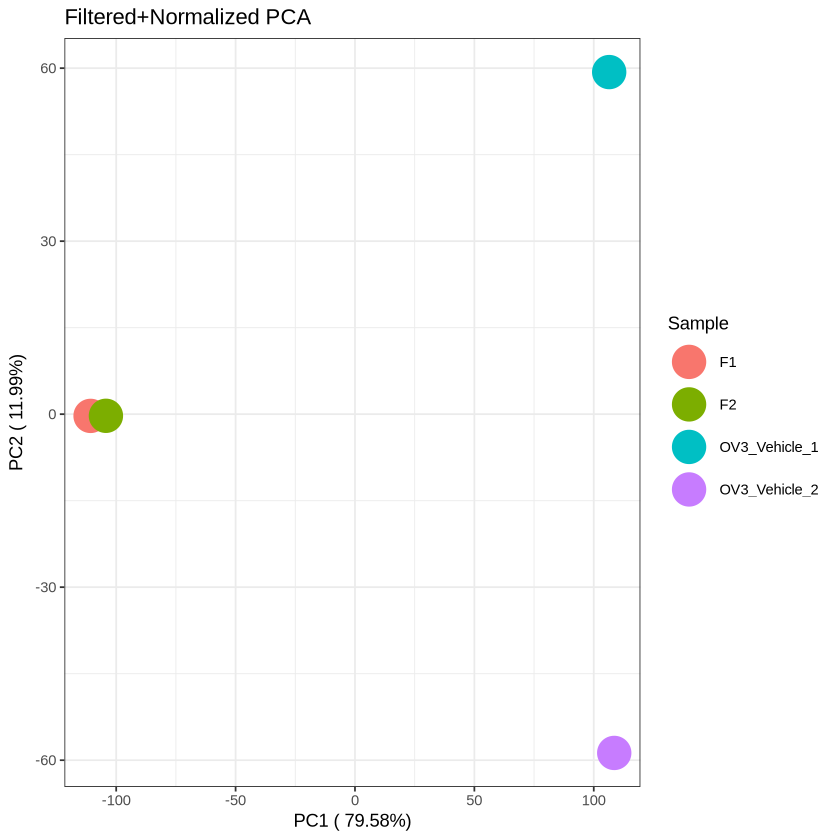

In [68]:
title = "Filtered+Normalized PCA"

pca_df = t(data.frame(gene_count_filt_norm))
keep_idx = apply(pca_df, 2, function(x) var(x) != 0)
pca_df = pca_df[,keep_idx]

pca_df = t(data.frame(gene_count_filt_norm))
keep_idx = apply(pca_df, 2, function(x) var(x) != 0)
pca_df = pca_df[,keep_idx]


pca_res = prcomp(pca_df, scale. = TRUE)
pca_res_df = data.frame(pca_res$x)
pca_res_df$Sample = row.names(pca_res_df)

percentage <- round(pca_res$sdev^2 / sum(pca_res$sdev^2) * 100, 2)
percentage <- paste( colnames(pca_res_df), "(", paste( as.character(percentage), "%", ")", sep="") )

options(repr.plot.width=7, repr.plot.height=7)

gg_pca = ggplot(pca_res_df,
            aes_string(x="PC1",y="PC2",label="Sample", color="Sample")) +
    geom_point(cex = 9)  +
    theme_bw() + xlab(percentage[1]) + ylab(percentage[2]) +
    ggtitle(title)

gg_pca

# now run DESeq2

In [52]:
samples_df = data.frame(run=sample_ids, condition=c("ctrl", "ctrl", "ov3_vehicle", "ov3_vehicle"))
rownames(samples_df) <- samples_df$run
samples_df

,run,condition
,<chr>,<chr>
F1,F1,ctrl
F2,F2,ctrl
OV3_Vehicle_1,OV3_Vehicle_1,ov3_vehicle
OV3_Vehicle_2,OV3_Vehicle_2,ov3_vehicle


In [53]:
# read in original RNASeq files again

gene_summarized <- readr::read_rds(gene_expr_file)
gene_count <- assay(gene_summarized, "counts")
sample_ids = colnames(gene_count)

gene_count_df = data.frame(gene_count)
gene_count_df = round(gene_count_df)

In [ ]:
# do analysis
dds <- DESeqDataSetFromMatrix(countData = gene_count_df,
                              colData = samples_df,
                              design = ~ condition)

smallestGroupSize <- 2
keep <- rowSums(counts(dds) >= 10) >= smallestGroupSize
dds <- dds[keep,]

dds <- DESeq(dds)
res <- results(dds)
res

converting counts to integer mode



Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition ov3 vehicle vs ctrl 
Wald test p-value: condition ov3 vehicle vs ctrl 
DataFrame with 15218 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat      pvalue
                 <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000000003   1083.727       0.408948 0.0931737   4.38910 1.13821e-05
ENSG00000000419   1481.973       0.449148 0.0824057   5.45045 5.02434e-08
ENSG00000000457    145.310       1.219776 0.2472039   4.93429 8.04414e-07
ENSG00000000460    648.689       0.947685 0.1258567   7.52987 5.07889e-14
ENSG00000001036   1928.112      -0.197614 0.0808725  -2.44352 1.45447e-02
...                    ...            ...       ...       ...         ...
ENSG00000285932   37.36627      -0.980399  0.507444  -1.93203 5.33554e-02
ENSG00000285943   99.85478       0.957458  0.391776   2.44389 1.45298e-02
ENSG00000285953  112.37261       1.991141  0.355707   5.59770 2.17213e-08
ENSG00000285976 3270.84013       0.625441

In [55]:
res <- results(dds, contrast=c("condition","ov3_vehicle","ctrl"))
res

log2 fold change (MLE): condition ov3_vehicle vs ctrl 
Wald test p-value: condition ov3 vehicle vs ctrl 
DataFrame with 15218 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat      pvalue
                 <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000000003   1083.727       0.408948 0.0931737   4.38910 1.13821e-05
ENSG00000000419   1481.973       0.449148 0.0824057   5.45045 5.02434e-08
ENSG00000000457    145.310       1.219776 0.2472039   4.93429 8.04414e-07
ENSG00000000460    648.689       0.947685 0.1258567   7.52987 5.07889e-14
ENSG00000001036   1928.112      -0.197614 0.0808725  -2.44352 1.45447e-02
...                    ...            ...       ...       ...         ...
ENSG00000285932   37.36627      -0.980399  0.507444  -1.93203 5.33554e-02
ENSG00000285943   99.85478       0.957458  0.391776   2.44389 1.45298e-02
ENSG00000285953  112.37261       1.991141  0.355707   5.59770 2.17213e-08
ENSG00000285976 3270.84013       0.625441

In [56]:
resOrdered <- res[order(res$pvalue),]
resOrdered

log2 fold change (MLE): condition ov3_vehicle vs ctrl 
Wald test p-value: condition ov3 vehicle vs ctrl 
DataFrame with 15218 rows and 6 columns
                 baseMean log2FoldChange     lfcSE         stat    pvalue
                <numeric>      <numeric> <numeric>    <numeric> <numeric>
ENSG00000005884  31948.46       -3.68900 0.0363044    -101.6128         0
ENSG00000009413   4960.36        3.17593 0.0589819      53.8458         0
ENSG00000026508   6797.49       -2.47609 0.0585491     -42.2909         0
ENSG00000038382   9308.84       -2.99838 0.0540576     -55.4665         0
ENSG00000038427   3184.17        4.13050 0.0687580      60.0730         0
...                   ...            ...       ...          ...       ...
ENSG00000137504  507.7065    2.67128e-04 0.1488067  1.79513e-03  0.998568
ENSG00000166780   72.7059   -2.43896e-04 0.3713602 -6.56763e-04  0.999476
ENSG00000188706 1525.3315   -3.89713e-05 0.0788242 -4.94408e-04  0.999606
ENSG00000263513  166.3265   -1.06960e-04 

In [57]:
summary(res)



out of 15218 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 5817, 38%
LFC < 0 (down)     : 6116, 40%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



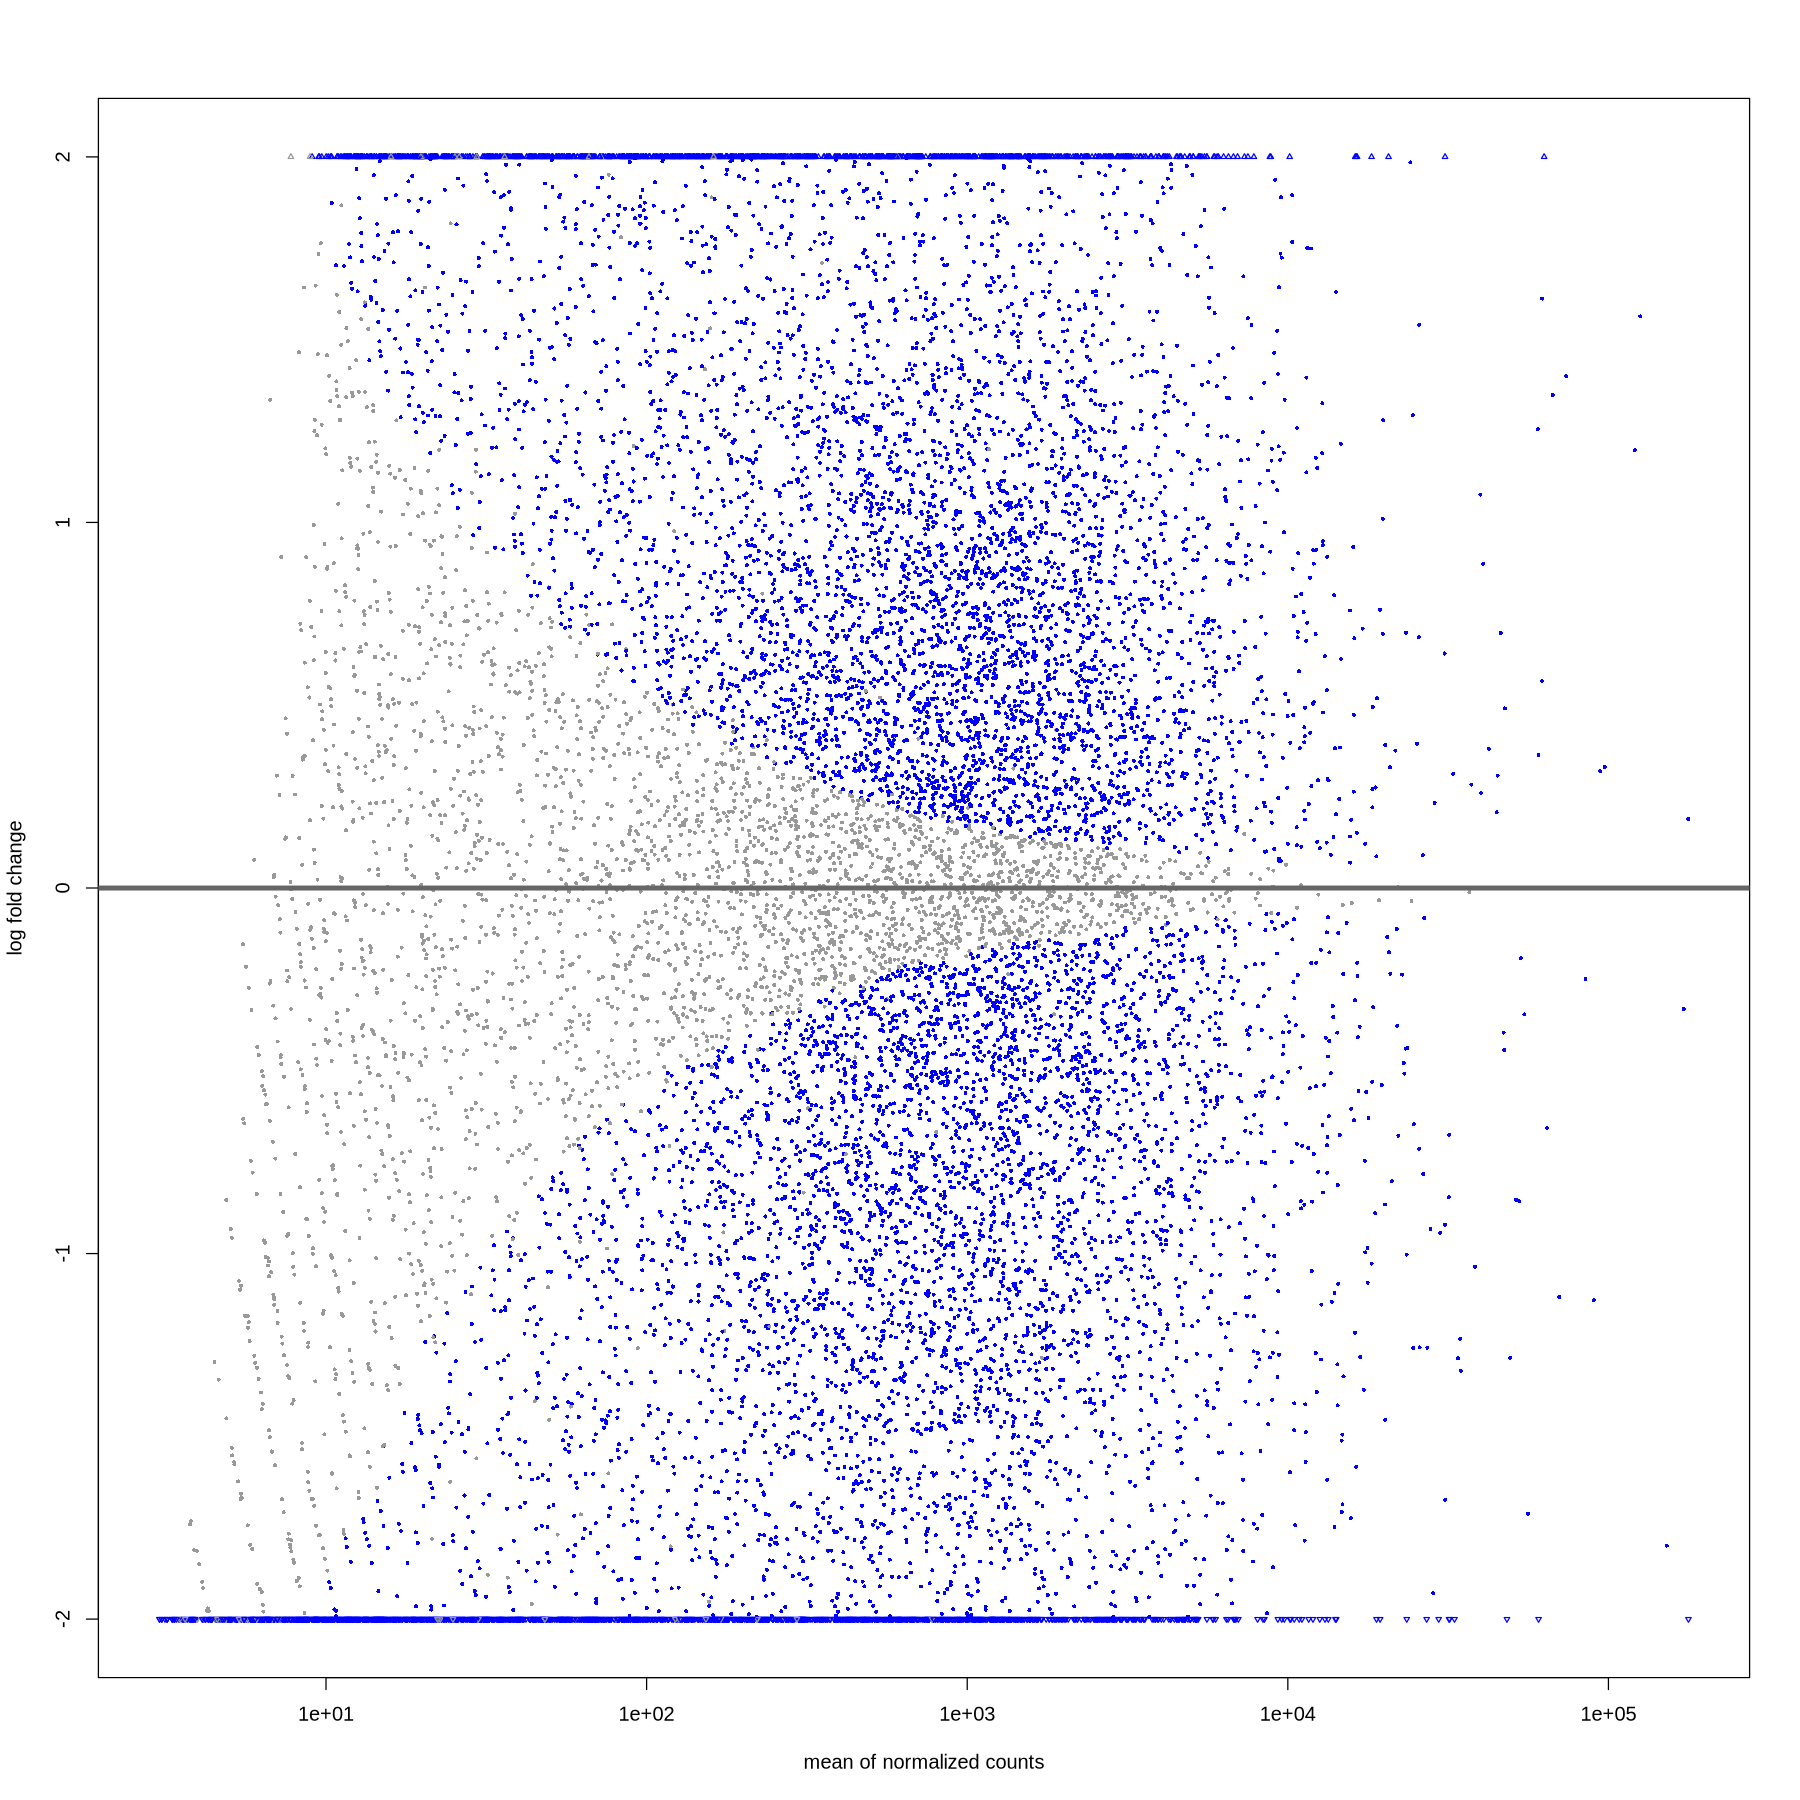

In [58]:
plotMA(res, ylim=c(-2,2))


In [59]:
#' Get translation table for gene ids of interest
#'
#' @param gene_vec, vector of gene ids to translate
#' @param filter_type, type of id used in genevec
#' @param attributes, the gene ids you are interested in returning
#' @return gene_ids_df, data frame of ensembl
#' and hgnc ids filtered by gene_vec
get_gene_id_map <- function(gene_vec, filter_type, attributes, all_chr=F){
    require('biomaRt')

    # must include filter type, in attributes
    # and chromosome
    attributes = na.omit(unique(c(filter_type, "chromosome_name", attributes)))

    # translate the gene names
    ensembl = useMart(biomart="ENSEMBL_MART_ENSEMBL",
                    dataset="hsapiens_gene_ensembl" ,
                    host="https://useast.ensembl.org")

    mart <- useDataset("hsapiens_gene_ensembl",
                    ensembl)

    if(is.na(filter_type)){
        gene_ids_df <- getBM(attributes= attributes,
                             mart= mart)

    }else{
        gene_ids_df <- getBM(filters= filter_type,
                             attributes= attributes,
                             values=gene_vec,
                             mart= mart)
    }



    # remove things from non-typical chromosomes
    if(!all_chr){
        # get all the genes with a non-canonical chromosome
        non_reg_chr = grep("HG|HS|NOVEL|PATCH|GL", unique(gene_ids_df$chromosome_name), value=T, invert=F)
        gene_ids_df = gene_ids_df[which(!gene_ids_df$chromosome_name %in% non_reg_chr),]

    }else if(length(intersect(c("ensembl_gene_id", "hgnc_symbol"), attributes) == 2)){

        # only remove from non-typical chromosome
        # if the gene is on another chromosome

        # remove genes with no hgnc_symbol
        gene_ids_df = subset(gene_ids_df, hgnc_symbol != "")

        # get all the genes with a non-canonical chromosome
        non_reg_chr = grep("HG|HS|NOVEL|PATCH|GL", unique(gene_ids_df$chromosome_name), value=T, invert=F)
        hgnc_nonreg = gene_ids_df[which(gene_ids_df$chromosome_name %in% non_reg_chr),]
        hgnc_reg = gene_ids_df[which(!gene_ids_df$chromosome_name %in% non_reg_chr),]

        # now only keep noncanonical IF it only has nonreg
        hgnc_has_only_nonreg = setdiff(unique(hgnc_nonreg$hgnc_symbol), unique(hgnc_reg$hgnc_symbol))
        hgnc_nonreg = hgnc_nonreg[which(hgnc_nonreg$hgnc_symbol %in% hgnc_has_only_nonreg),]

        # for the nonreg keep the most updated one
        hgnc_nonreg = hgnc_nonreg[order(hgnc_nonreg$ensembl_gene_id), ]
        hgnc_nonreg_dup = which(!duplicated(hgnc_nonreg$hgnc_symbol))
        hgnc_nonreg = hgnc_nonreg[hgnc_nonreg_dup, ]

        gene_ids_df = rbind(hgnc_reg, hgnc_nonreg)
    }

    return(gene_ids_df)

}

In [60]:
gene_ids_df <- get_gene_id_map(rownames(res),
                filter_type="ensembl_gene_id",
                attributes=c("hgnc_symbol"),
                all_chr=F)


In [61]:
res$ensembl_gene_id = row.names(res)
res_hgnc = merge(as.data.frame(res), gene_ids_df, all=T)


In [62]:
res_hgnc = res_hgnc[order(res_hgnc$padj,decreasing = F),]

write.table(as.data.frame(res_hgnc), 
          file=res_file, sep="\t")

Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”


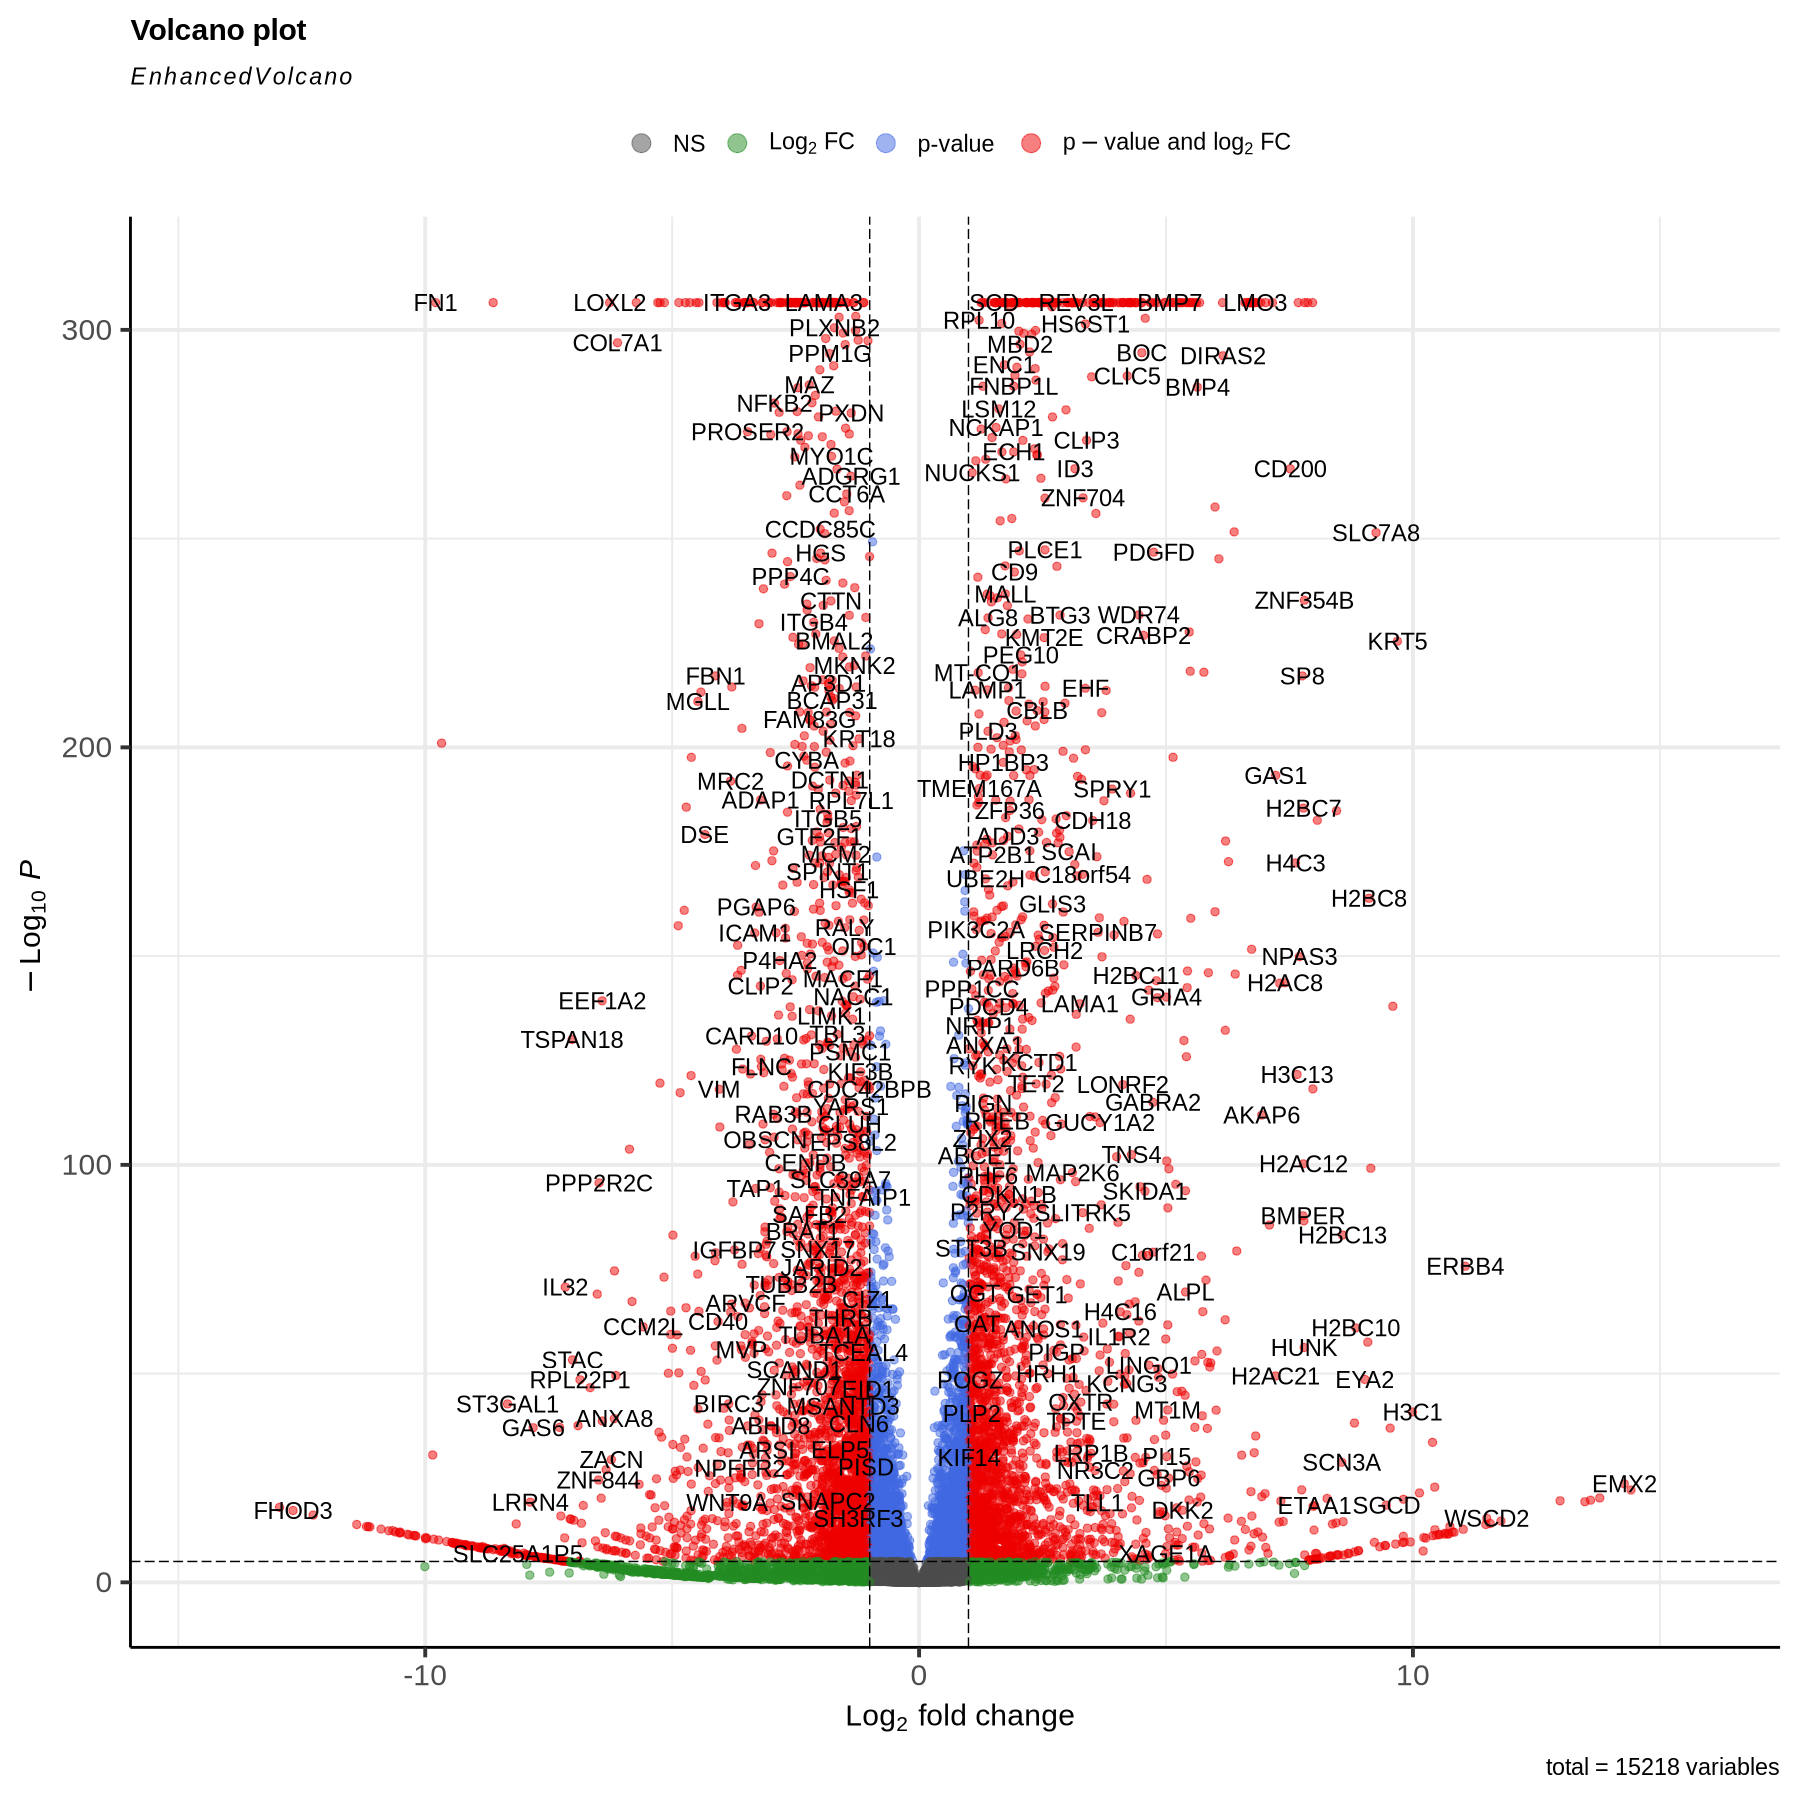

In [63]:
options(repr.plot.width=15, repr.plot.height=15)

EnhancedVolcano(res_hgnc,
    lab = res_hgnc$hgnc,
    x = 'log2FoldChange',
    y = 'padj')

In [64]:

gene_count_df$ensembl_gene_id = row.names(gene_count_df)
gene_count_df = merge(as.data.frame(gene_count_df), gene_ids_df, all=T)

write.table(gene_count_df, 
          file=data_formatted_file, sep="\t")